# Predefined functions

In [1]:
import pandas as pd

# Getting data
def getData(url, sheet_name=0, skiprows=0, truncate=-1, index_column='County Name'):
    df = pd.read_excel(url, sheet_name=sheet_name, skiprows=skiprows)
    if truncate > -1:
        df = df.truncate(before=0, after=truncate)
    df = df.set_index(index_column)
    return df

In [2]:
def config_subplot(ax, label, fontsize=12, ticker_count=3):
    # axis label
    ax.set_title(label, fontdict={'fontsize':fontsize})
    # number of tickers
    ax.xaxis.set_major_locator(ticker.MaxNLocator(ticker_count))
    # ticker formatter
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

# Data collection

## Cumulative case count

In [3]:
url = "https://dshs.texas.gov/coronavirus/TexasCOVID19DailyCountyCaseCountData.xlsx"
cases_df = getData(url, skiprows=2, truncate=253)

In [4]:
import re
pattern = re.compile('[0-9]+-[0-9]+', re.IGNORECASE)
cases_df.columns = [pattern.findall(sub)[0] for sub in cases_df.keys()]

from datetime import datetime
dates = [datetime.strptime(date, '%m-%d') for date in cases_df.keys()]

### Scale the data down to per 100k capita

In [5]:
pop_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv"
pop_df = pd.read_csv(pop_url, engine='python')
pop_df = pop_df.rename(columns={'CTYNAME': 'County Name'})
pop_df = pop_df.set_index('County Name')
# filter Texas counties
pop_df = pop_df[pop_df['STNAME'] == 'Texas']
# get latest population
pop_df = pop_df[pop_df.filter(like='2019').columns[0]]
# remove suffix ' County' in name
pop_df.index = pop_df.index.map(lambda x: x.replace(' County', ''))

In [6]:
scaled_cases_df = cases_df.apply(lambda row: row * 1e5 / pop_df[row.index])
scaled_cases_df.shape

(254, 208)

## Metro / Non-metro

The data is retrieved from 2013 NCHS Urban–Rural Classification Scheme, in which six levels scheme are defined according to the
following classification rules:
### Metropolitan categories

**Large central metro**—Counties in MSAs of 1 million or more population that:
1.	 Contain the entire population of the largest principal city of the MSA, or
2.	 Have their entire population contained in the largest principal city of the MSA, or
3.	 Contain at least 250,000 inhabitants of any principal city of the MSA.

**Large fringe metro**—Counties in MSAs of 1 million or more population that did not qualify as large central metro counties.

**Medium metro**—Counties in MSAs of populations of 250,000 to 999,999.  

**Small metro**—Counties in MSAs of populations less than 250,000.

### Nonmetropolitan categories

**Micropolitan**—Counties in micropolitan statistical areas.

**Noncore**—Nonmetropolitan counties that did not qualify as micropolitan.

In [7]:
metro_url = "http://www.dshs.state.tx.us/chs/info/TxCoPhrMsa.xls"
metro_df = getData(metro_url, truncate=253)
metro_df = metro_df[[metro_df.filter(like='2013').columns[0], metro_df.filter(like='Metro Area').columns[0]]]
#metro_df

## Merging all into one dataframe

In [8]:
# population
merged_df = pd.merge(pop_df, metro_df, on='County Name', how='inner')
# metro classificiation
merged_df = pd.merge(merged_df, scaled_cases_df, on='County Name', how='outer')
# rename column
keys = merged_df.keys()
merged_df = merged_df.rename(columns={keys[0]: 'Population', keys[1]: 'Classification', keys[2]: 'MetroArea'})
merged_df

,Population,Classification,MetroArea,03-04,03-05,03-06,03-09,03-10,03-11,03-12,...,09-21,09-22,09-23,09-24,09-25,09-26,09-27,09-28,09-29,09-30
County Name,,,,,,,,,,,,,,,,,,,,,
Anderson,57735,Micropolitan,Non-Metro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4835.888109,4851.476574,4887.849658,4893.045813,4905.170174,4919.026587,4919.026587,4919.026587,4891.313761,4905.170174
Andrews,18705,Micropolitan,Non-Metro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2202.619620,2202.619620,2218.658113,2218.658113,2272.119754,2272.119754,2272.119754,2272.119754,2272.119754,2272.119754
Angelina,86715,Micropolitan,Non-Metro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2436.717984,2444.790405,2444.790405,2444.790405,2472.467278,2472.467278,2472.467278,2472.467278,2482.846105,2494.378135
Aransas,23510,Medium Metro,Metro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1356.869417,1361.122926,1361.122926,1369.629945,1369.629945,1373.883454,1373.883454,1373.883454,1373.883454,1373.883454
Archer,8553,Small Metro,Metro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,806.734479,923.652520,923.652520,958.727932,993.803344,1017.186952,1017.186952,1017.186952,1017.186952,1017.186952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wood,45539,Non-core,Non-Metro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1089.176310,1113.331430,1126.506950,1126.506950,1139.682470,1152.857990,1152.857990,1152.857990,1155.053910,1155.053910
Yoakum,8713,Non-core,Non-Metro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2306.897739,2329.851945,2329.851945,2444.622977,2536.439803,2570.871112,2570.871112,2570.871112,2570.871112,2570.871112
Young,18010,Non-core,Non-Metro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1476.957246,1565.796780,1632.426430,1671.293726,1687.951138,1743.475847,1743.475847,1743.475847,1815.657968,1843.420322


# Plotting

In [9]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.dates as mdates

figsize=(20,10)
title_size = 24
label_size = 18
ticker_count= 8
line_width = 2.5

## 7-day average daily case count

C:\Users\ASUS\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\ASUS\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


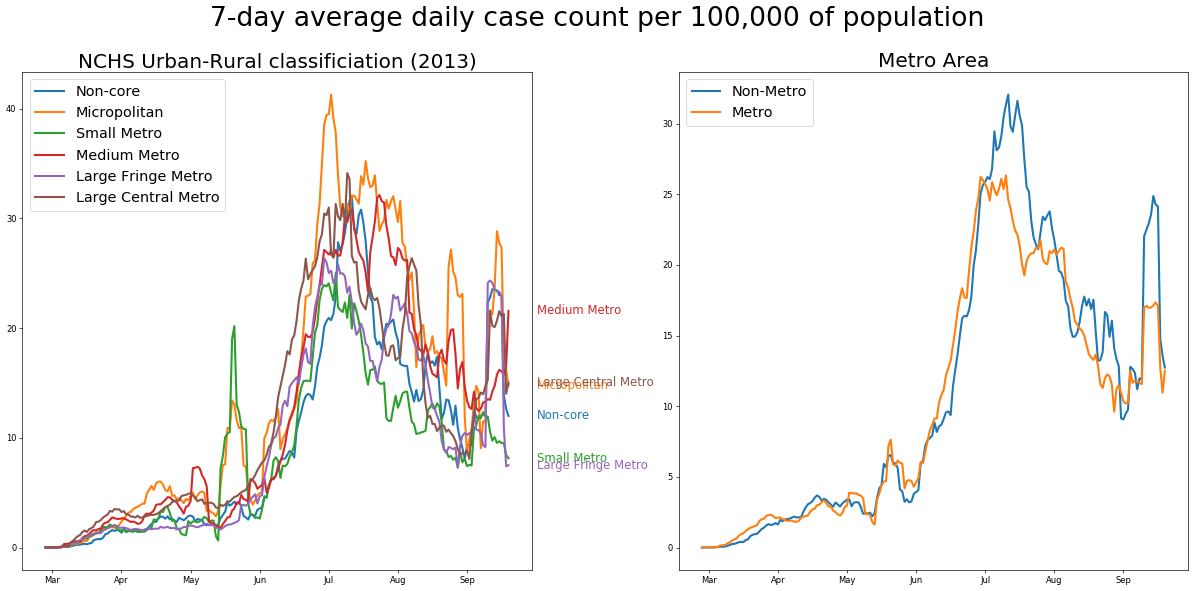

In [10]:
# create figure
fig = plt.figure(figsize=figsize, dpi=60)
fig.suptitle('7-day average daily case count per 100,000 of population', fontsize=32)
# and its subplots
ax1 = fig.add_subplot(1, 2, 1)
config_subplot(ax1, 'NCHS Urban-Rural classificiation (2013)', title_size, ticker_count)
ax2 = fig.add_subplot(1, 2, 2)
config_subplot(ax2, 'Metro Area', title_size, ticker_count)

# plotting average values of each metro classification
# for label, df in merged_df.groupby('Classification', sort=True):
metro_cls = ['Non-core', 'Micropolitan', 'Small Metro', 'Medium Metro', 'Large Fringe Metro', 'Large Central Metro']
for cls in metro_cls:
    df = merged_df[merged_df['Classification'] == cls].iloc[:,3:]
    df = df.mean().diff().rolling(window=7).mean()
    #print(df.iloc[:,:-1].max().max())
    ax1.plot(dates, df, label=cls, linewidth=line_width)

# plotting average values of each metro classification
metro_types = ['Non-Metro', 'Metro']
for metro_type in metro_types:
    df = merged_df[merged_df['MetroArea'] == metro_type].iloc[:,3:]
    df = df.mean().diff().rolling(window=7).mean()
    ax2.plot(dates, df, label=metro_type, linewidth=line_width)

# using same ylim
# ax1.set_ylim(0, 45);
# ax2.set_ylim(0, 45);
    
# configure legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper left', fontsize='xx-large')
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, loc='upper left', fontsize='xx-large')

# configure legend on lines
for line, name in zip(ax1.lines, metro_cls):
    y = line.get_ydata()[-1]
    ax1.annotate(name, xy=(1,y), xytext=(6,0), color=line.get_color(), 
                xycoords = ax1.get_yaxis_transform(), textcoords="offset points",
                size=14, va="center")
    
fig.tight_layout()
fig.subplots_adjust(top=0.87)

fig.savefig('graphs/hypothesis_8_1.png')

Contrary to the hypothesis, the daily number of new cases of rural counties appears to be a little higher than those urban ones, especially with micropolitan counties top the graph during the outbreak period. Small-metro counties seems to has least spread, while other types are somewhat similar to each other.

When we combine them into 2 main caterogies metro or non-metro, it even becomes clearer when those metro counties are almost always equal or lower than non-metro counterparts.

## Heatmap

### Calculating average daily cases by month 

In [11]:
import calendar

avg_month_df = merged_df.iloc[:,:3]
for month in range(1,12,1):
    df = merged_df.filter(like='{:02d}-'.format(month))
    if df.shape[1] > 0:
        avg_month_df[calendar.month_name[month]] = df.mean(axis=1).values
# avg_month_df

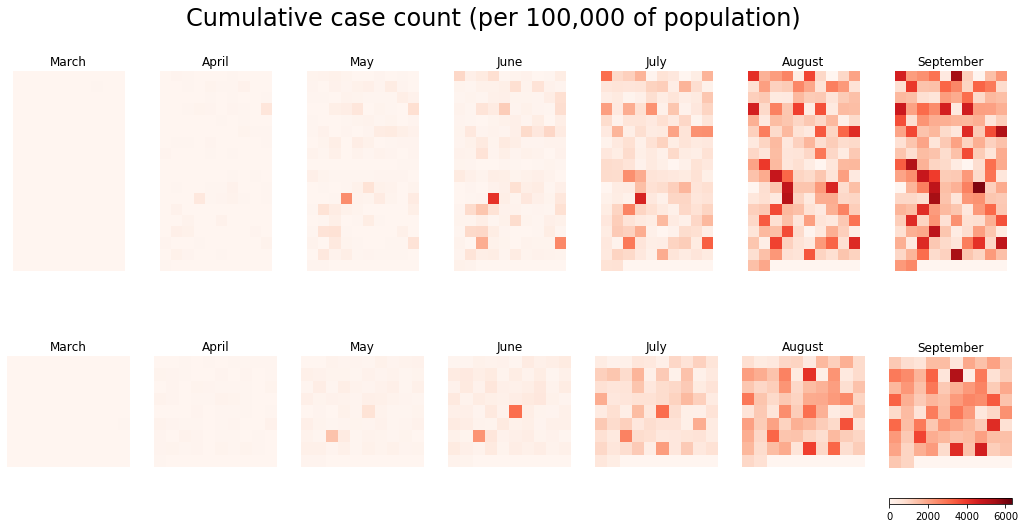

In [12]:
import numpy as np
from matplotlib.pyplot import cm

# configure figure
fig_size = 6
fig2 = plt.figure(figsize=(fig_size*3, fig_size*1.5))
fig2.suptitle('Cumulative case count (per 100,000 of population)', fontsize=title_size)
# fig2.text(0.085, 0.5, "Cumulative case count (per 100,000 of population)", va="center", rotation=90, fontsize=14)

# determine y-lim
vmax = merged_df.iloc[:,3:].max().max()

idx = 0
for i, metro_type in enumerate(metro_types):
    # filter by metro area
    avg_month_type_df = avg_month_df[avg_month_df['MetroArea'] == metro_type].iloc[:,3:]
    for month in avg_month_type_df:
        # padding
        col = avg_month_type_df[month].values
        col = np.pad(col, (0, 10 - col.shape[0] % 10), 'constant')
        col = col.reshape((-1,10))
        # plotting
        idx += 1
        ax = fig2.add_subplot(2, 7, idx)
        ax.set_title(month, fontdict={'fontsize':12})
        heatmap = ax.imshow(col, cmap=cm.Reds, vmax=vmax)
        ax.set_axis_off()
        
# configure colorbar
fig2.subplots_adjust(bottom=0.2)
fig2.colorbar(heatmap, orientation="horizontal", fraction=0.07,anchor=(1.0,0.0))

fig2.savefig('graphs/hypothesis_8_2.png')

Looking at corresponding heatmap of those two types, we can clearly see that there is also way many more counties with darker color in non-metro type, indicating greater spread compared to metro counties.

## Scatterplot

### Melting Daily into Month for easier plotting

In [13]:
melt_avg_month_df = avg_month_df.drop(avg_month_df.keys()[3], axis=1)
keys = melt_avg_month_df.keys()
melt_avg_month_df = pd.melt(melt_avg_month_df, id_vars=keys[:3], value_vars=keys[3:], var_name='Month', value_name='Daily')
# melt_avg_month_df.sort_values(by=['Population'])
melt_avg_month_df

,Population,Classification,MetroArea,Month,Daily
0,57735,Micropolitan,Non-Metro,April,14.087353
1,18705,Micropolitan,Non-Metro,April,71.103983
2,86715,Micropolitan,Non-Metro,April,26.216149
3,23510,Medium Metro,Metro,April,6.947398
4,8553,Small Metro,Metro,April,0.000000
...,...,...,...,...,...
1519,45539,Non-core,Non-Metro,September,1030.764839
1520,8713,Non-core,Non-Metro,September,2199.012969
1521,18010,Non-core,Non-Metro,September,1466.962798
1522,14179,Micropolitan,Non-Metro,September,2226.532196


C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


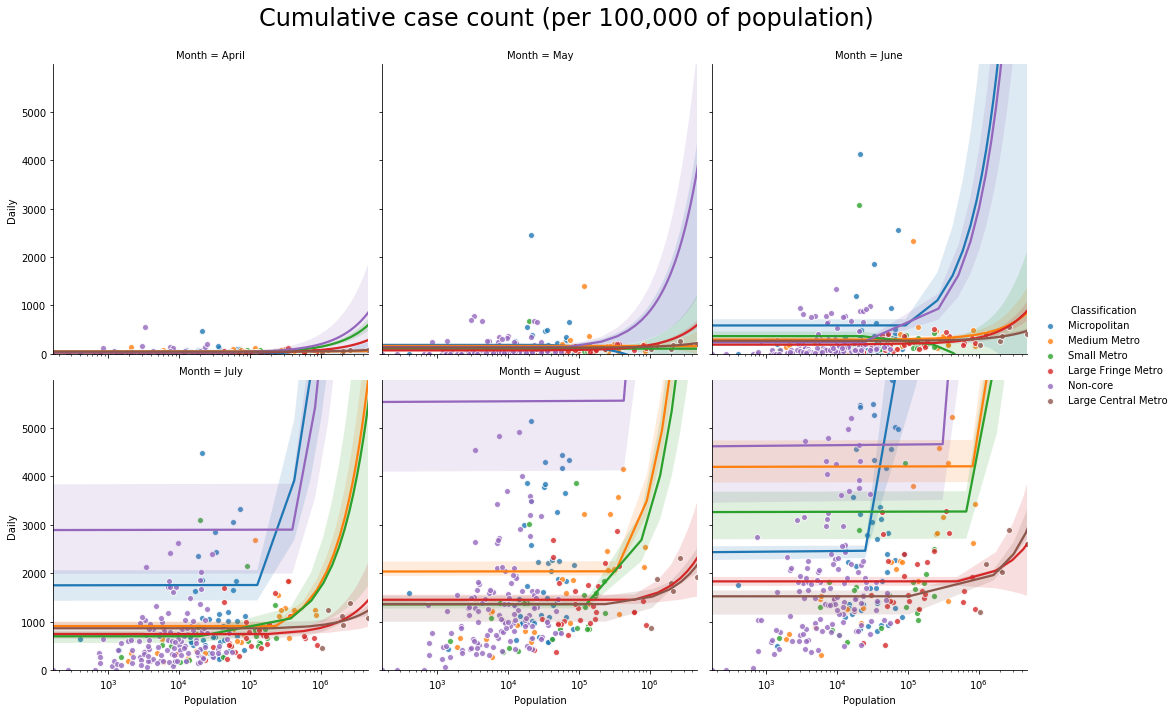

In [14]:
import seaborn as sns

g = sns.lmplot(data=melt_avg_month_df, col='Month', x='Population', y='Daily', scatter=True,
               hue='Classification', col_wrap=3, ci=40, scatter_kws={'linewidths':1, 'edgecolor':'w'})

# log xscale and set axis limits
pop = melt_avg_month_df['Population']
daily = melt_avg_month_df['Daily']
g.set(xlim=(pop.min(), pop.max()), ylim=(daily.min(), daily.max()), xscale='log')

# add title
fig4 = g.fig
fig4.subplots_adjust(top=0.9)
fig4.suptitle('Cumulative case count (per 100,000 of population)', fontsize=title_size)

g.savefig('graphs/hypothesis_8_3.png')

### Without regression

In [15]:
# import seaborn as sns

# cols=3
# fig3, axes = plt.subplots(2, cols, figsize=(15,10))
# fig3.suptitle('Cumulative case count (per 100,000 of population)', fontsize=title_size)

# ylim = avg_month_df.iloc[:,3:].max().max()
# for month in range(4, 10, 1):
#     idx = month - 4
#     ax = axes[int(idx/cols)][idx%cols]
#     ax.set_ylim(0, ylim);
#     g = sns.scatterplot(data=avg_month_df, x="Population", y=calendar.month_name[month], hue='Classification', ax=ax)
#     g.set(xscale="log")
#     ax.get_legend().remove()
    
# handles, labels = axes[1][2].get_legend_handles_labels()
# fig3.legend(handles, labels, loc='upper right')

# fig3.savefig('graphs/hypothesis_8_4.png')

# Performing statistical tests

Null hypothesis (H0): There is no difference between spread rate of rural and urban counties.  
Alternative hypothesis (H1): Rural counties had different spread rate from urban counties.

In [16]:
from scipy import stats
import time
np.random.seed(int(time.time()))

## Paired T-Test

Splitting the data into metro and non-metro

In [17]:
case_metro_df = merged_df[merged_df['MetroArea'] == 'Metro'].iloc[:,3:].mean()
case_non_metro_df = merged_df[merged_df['MetroArea'] == 'Non-Metro'].iloc[:,3:].mean()

then perform paired T-Test on them

In [18]:
# stats.ttest_ind(case_non_metro_df.mean(), case_metro_df.mean(), equal_var = False)
stats.ttest_rel(case_non_metro_df, case_metro_df)

Ttest_relResult(statistic=3.7628398970163275, pvalue=0.0002187368710780744)

The p-value is 0.001, which is less than the stardard threshold 0.05 and 0.01, so we reject the null hypothesis and we can say that rural counties had different spread rate from urban ones.

## Chi-square test

On a second thought, chi-square test might not be suitable for this problem

In [19]:
# first_not_zero = max((case_metro_df != 0).idxmax(), (case_non_metro_df != 0).idxmax())
# no_zero_metro_df = case_metro_df[first_not_zero:]
# no_zero_non_metro_df = case_non_metro_df[first_not_zero:]
# max_case = max(no_zero_metro_df[-1], no_zero_non_metro_df[-1])

max_case = max(case_metro_df[-1], case_non_metro_df[-1])
interval = 400
intervals = range(0, int(max_case + interval), interval)
expected = case_metro_df.groupby(pd.cut(case_metro_df, intervals)).count()
observed = case_non_metro_df.groupby(pd.cut(case_non_metro_df, intervals)).count()

#stats.chisquare(case_metro_df.mean(), case_non_metro_df.mean(), ddof=case_metro_df.shape[0]-1)
stats.chisquare(observed.values, f_exp=expected, ddof=observed.shape[0]-1)

Power_divergenceResult(statistic=5.636135383503804, pvalue=nan)

## ANOVA

Attemp to split data into 3 categories: small, medium and large population, then perform ANOVA on them

In [20]:
cls = merged_df['Classification']
rural = merged_df[cls.isin(['Non-core', 'Micropolitan'])].iloc[:,3:]
mixed = merged_df[cls.isin(['Small Metro', 'Medium Metro'])].iloc[:,3:]
urban = merged_df[cls.isin(['Large Fringe Metro', 'Large Central Metro'])].iloc[:,3:]
stats.f_oneway(rural.mean(), mixed.mean(), urban.mean())

F_onewayResult(statistic=0.15777244869403984, pvalue=0.8540783212808899)

the same approach as above, but use all 5 classifications instead

In [21]:
stats.f_oneway(*merged_df.groupby('Classification').mean().values)

F_onewayResult(statistic=0.9247725770540007, pvalue=0.46387723896480193)

Both results are much larger than standard thresholds, so we do not have enough evidence to reject the hypothesis.